Do volume flattening based on the picked horizons that come with teapot dome

In [1]:
import pandas as pd
import numpy as np
horizon_path = '/home/dparks/Downloads/rmotc/DataSets/Seismic/CD files/3D_Seismic/3DHorizons.xyz'
segy_path = '/home/dparks/Downloads/rmotc/DataSets/Seismic/CD files/3D_Seismic/filt_mig.sgy'
#from the sismic
in_max = 345
xl_max = 188

in_min = 1
xl_min = 1

sample_rate = 0.002

in_len = (in_max - in_min) + 1;
xl_len = (xl_max - xl_min) + 1;

def hznToNp(hzn):
    """
    Take a pandas list of rows for a horizon and covnert to a 2d numpy array. 
    """
    result = np.zeros((in_len, xl_len))
    
    for i,row in hzn.iterrows():
        x = int(row['inline'] - in_min)
        y = int(row['xline'] - xl_min)

        result[x][y] = float(row['Time'])
        
    return result

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def read_horizons(horizon_path):
    """
    Read horizons from disk
    """
    with open(horizon_path) as f:
        hznDF = pd.read_csv(f, header=0, delim_whitespace=True)

        hznDF['inline'].astype(np.int32)
        hznDF['xline'].astype(np.int32)
        hznDF['Time'].astype(np.float32)
        
        gb = hznDF.groupby("Horizon")

        horizons = gb.apply(hznToNp)
        return list(zip(gb.groups.keys(), horizons)) 
   
#List of tuples of horizon names and horizon np arrays. Looks like [("horizon_name", np_array_floats),...]
horizons = read_horizons(horizon_path)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def show_plot(i):
    name, horizon = horizons[i]
    flattened = horizon.flatten() 

    print(name)
    nonZeroMin = min(filter(lambda x: x != 0, flattened.tolist()))
    
    plt.figure(figsize=(16,8))
    plt.imshow(horizon, cmap="jet", vmin=nonZeroMin, vmax=horizon.max(), aspect=0.25)
    plt.colorbar(shrink=0.5)
    plt.show()
#todo replace this with a drop down
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
interact(show_plot, i=widgets.IntSlider(min=0, max=len(horizons)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='i', max=8), Output()), _dom_classes=('widget-interact',)…

<function __main__.show_plot(i)>

In [3]:
def save_horizon(name, horizon):
    np.save('%s_Horizon' % name, horizon)

def read_segy(filename):
    """
    Read in a stacked segy volume in a np array
    """
    from obspy.io.segy.segy import _read_segy
    stream = _read_segy(filename, headonly=True)

    traces_with_indexes = []

    for trace in stream.traces:
        x = trace.header.x_coordinate_of_ensemble_position_of_this_trace - 1
        y = trace.header.y_coordinate_of_ensemble_position_of_this_trace - 1

        traces_with_indexes.append((x,y, trace.data))
        
    x_max = max(traces_with_indexes, key = lambda x: x[0])[0]
    y_max = max(traces_with_indexes, key = lambda x: x[1])[1]

    x_len = x_max + 1
    y_len = y_max + 1
    s_len = len(traces_with_indexes[0][2])
    threeDSamples = np.zeros((x_len, y_len, s_len))
    
    for xy_trace in traces_with_indexes:
        x = xy_trace[0]
        y = xy_trace[1]
        samples = xy_trace[2]
        threeDSamples[x, y] = samples
    return threeDSamples

data = read_segy(segy_path)


(345, 188, 41)


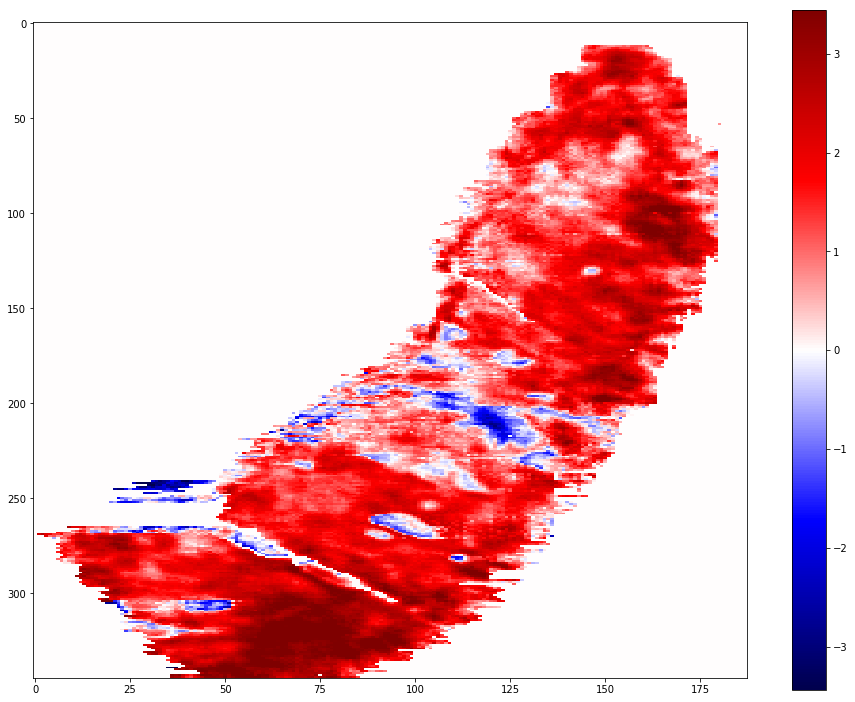

In [4]:
def strat_slice(data, horizon_times, window_size):
    s_len = 2 * window_size + 1
    x_len , y_len = horizon_times.shape
    result = np.zeros((x_len, y_len, s_len))
    
    for ix,iy in np.ndindex(horizon_times.shape):
        time = horizon_times[ix,iy]
        
        if time == 0.0:
            continue
        
        ik = min(int(time/sample_rate + 0.5), data.shape[2] - 1)
        
        indexes = np.linspace(ik - window_size, ik + window_size + 1, num=s_len)
        indexes = np.clip(indexes, 0, data.shape[2]-1)
        indexes = indexes.astype(np.int, copy=False)
        result[ix,iy] = data[ix,iy,  indexes]
    
    return result

def save_strat_slice(name, strat_block):
    np.save('%s_strat_block' % name, strat_block)

samples_around_horizon = 20

#Save stratal slices to disk

for horizon_name, horizon_times in horizons:
    strat_data = strat_slice(data, horizon_times, samples_around_horizon)
    save_strat_slice(horizon_name.replace("/","_"), strat_data)
    

print(strat_data.shape)
strat_data = strat_data[:,:,samples_around_horizon]

vm = np.percentile(strat_data, 99)

plt.figure(figsize=(16,25))
plt.imshow(strat_data, cmap="seismic", vmin=-vm, vmax=vm, aspect=0.5)
plt.colorbar(shrink=0.5)
plt.show()

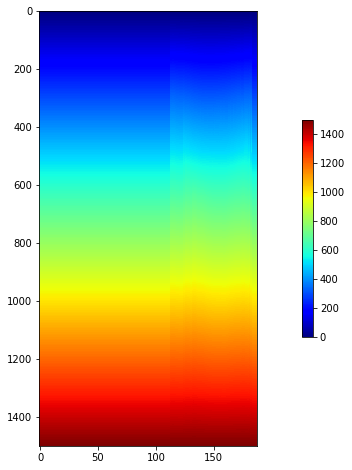

In [5]:
def shifts_to_flatten_all_horizons(data_shape, horizons):
    """
    Compute the shift that is needed to flatten all of the picked horizon
    """
    from scipy.interpolate import interp1d
    shifts = np.zeros(data_shape)
    
    s_len = data_shape[2]
    
    avg_depths = {}
    for horizon_name, horizon_times in horizons:
        sum_ik = 0
        count_ik = 0
        for ix,iy in np.ndindex(data_shape[:2]):
            time = horizon_times[ix, iy]
            
            if time == 0.0:
                continue
            
            ik = time/sample_rate
            sum_ik += ik
            count_ik += 1
        avg_ik = sum_ik/count_ik 
        avg_depths[horizon_name] = avg_ik

    
    for ix,iy in np.ndindex(data_shape[:2]):
        shift_index_x = [(0.)] 
        shift_index_y = [(0.)] 
        
        for horizon_name, horizon_times in horizons:
            time = horizon_times[ix, iy]
        
            if time == 0.0:
                continue

            ik = -1 * (avg_depths[horizon_name] - time/sample_rate)
        
            shift_index_x.append(avg_depths[horizon_name])
            shift_index_y.append(ik)
        
        shift_index_x.append(s_len)
        shift_index_y.append(0)
        
        interp_func = interp1d(np.array(shift_index_x), np.array(shift_index_y), kind='linear')
        
        indexes = np.linspace(0.0, s_len, num=s_len)
        shifts[ix, iy] = interp_func(indexes)
        shifts[ix, iy] += indexes
        shifts[ix, iy] = np.clip(shifts[ix, iy], 0, s_len-1)
    return shifts

shifts = shifts_to_flatten_all_horizons(data.shape, horizons)

plt.figure(figsize=(16,8))
plt.imshow(shifts[50].T, cmap="jet", aspect=0.25)
plt.colorbar(shrink=0.5)
plt.show()


In [6]:
def apply_shifts(data, shifts):
    from scipy.interpolate import interp1d
    result = np.empty_like(data)
    #result[:, :, :] = data[shifts[:, :, :]]
    s_len = data.shape[2]
    z_indexes = np.linspace(0.0, s_len, num=s_len)
    for ix,iy in np.ndindex(data.shape[:2]):
        interp_func = interp1d(z_indexes, data[ix, iy], kind='cubic')
        
        result[ix, iy] = interp_func(shifts[ix, iy])
    return result

print(data.shape)
print(shifts.shape)
flattened = apply_shifts(data, shifts)

(345, 188, 1501)
(345, 188, 1501)


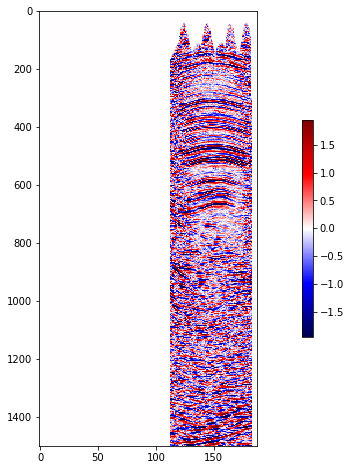

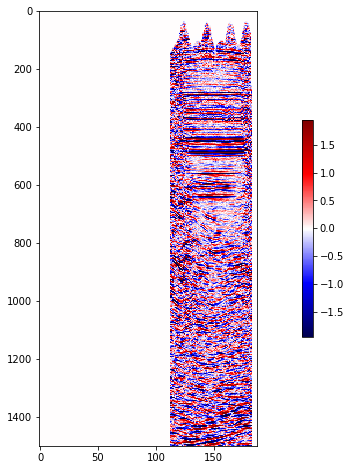

In [7]:
vm = np.percentile(data, 99)

plt.figure(figsize=(16,8))
plt.imshow(data[50].T, cmap="seismic", vmin=-vm, vmax=vm, aspect=0.25)
plt.colorbar(shrink=0.5)
plt.show()

plt.figure(figsize=(16,8))
plt.imshow(flattened[50].T, cmap="seismic", vmin=-vm, vmax=vm, aspect=0.25)
plt.colorbar(shrink=0.5)
plt.show()

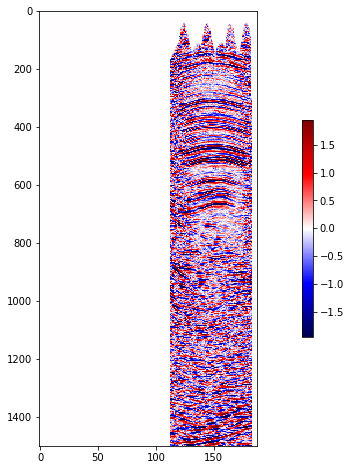

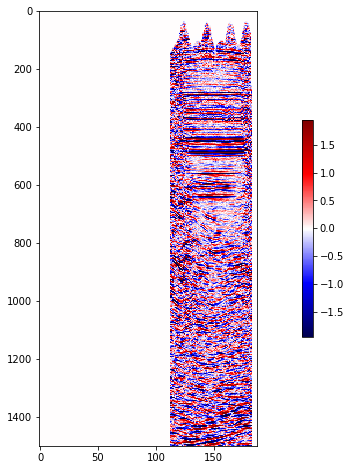

In [8]:
vm = np.percentile(data, 99)

plt.figure(figsize=(16,8))
plt.imshow(data[50].T, cmap="seismic", vmin=-vm, vmax=vm, aspect=0.25)
plt.colorbar(shrink=0.5)
plt.show()

plt.figure(figsize=(16,8))
plt.imshow(flattened[50].T, cmap="seismic", vmin=-vm, vmax=vm, aspect=0.25)
plt.colorbar(shrink=0.5)
plt.show()

In [9]:
def show_time_slice(i):
    
    plt.figure(figsize=(16,20))
    plt.imshow(flattened[:,:,i], cmap="Greys", vmin=-vm, vmax=vm, aspect=0.5)
    plt.colorbar(shrink=0.5)
    plt.show()

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
interact(show_time_slice, i=widgets.IntSlider(min=0, max=flattened.shape[2], step=1, value=589))

interactive(children=(IntSlider(value=589, description='i', max=1501), Output()), _dom_classes=('widget-intera…

<function __main__.show_time_slice(i)>

In [10]:
np.save('teapot', data)
np.save('teapot_flat', flattened)